# Running DeepAR on first set of Munchkin data

Separately loaded up a subset of the Munchkin data into S3, prepped into the format that DeepAR expects to use.

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Seems like I have to reinstall s3fs, even though I only stopped and started the instance.  That seems odd.

In [3]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.7
  latest version: 4.4.10

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - s3fs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.1.18          |           py36_0         144 KB
    s3fs-0.1.2                 |           py36_0          31 KB
    ------------------------------------------------------------
                                           Total:         175 KB

The following NEW packages will be INSTALLED:

    s3fs:    0.1.2-py36_0              

The following packages will be UPDATED:

    certifi: 2017.7.27.1-py36h8b7b77e_0 --> 2018.1.18-py36_0


certifi 2018.1.18: ##################################################### | 100% 
s3f

In [5]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:  
* The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
* The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook.

In [6]:
bucket = 'sagemaker-w210-022318'
prefix = 'Deeptest_1'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [7]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

## Specify overall parameters

Specify we have weekly frequency data.  

Want to predict for the next 17 weeks (to allow us to predict weeks 14-17 before week 1, which is the business use case).

Going to choose to use 26 weeks of context to make the predictions.  (Note: DeepAR automatically checks for typical seasonal windows with lagged inputs so don't need to specify a window greater than a year for it to include seasonal effects.)

In [8]:
freq = 'W'
prediction_length = 17
context_length = 26

## Train a model

We can now define the estimator that will launch the training job.

Have picked data of the same order of magnitude as the tutorial, so just leave the same instance specifications for now, except for job name.

In [14]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DeepAR-M1',
    output_path="s3://" + s3_output_path
)

Now need to set hyperparameters.

Keeping the network size the same as the tutorial example.

Set likelihood to negative binomial as we have count data

Leave epochs, batch size, learning rate as in the tutorial.

In [15]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "negative-binomial",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [16]:
estimator.set_hyperparameters(**hyperparameters)

In [12]:
s3_data_path

'sagemaker-w210-022318/Deeptest_1/data'

Now launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last prediction_length points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [17]:
%%time

data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DeepAR-M1-2018-02-23-17-56-43-759


........................................................

ValueError: Error training DeepAR-M1-2018-02-23-17-56-43-759: Failed Reason: ClientError: Data download failed:Supplied bucket is not in the region associated with the training job (us-east-1)

## Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note**: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [26]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2018-02-21-18-51-10-073
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2018-02-21-18-51-10-073
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2018-02-21-18-51-10-073


----------------------------------------------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [27]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [28]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions and plot results

Now we can use the previously created predictor object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [29]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

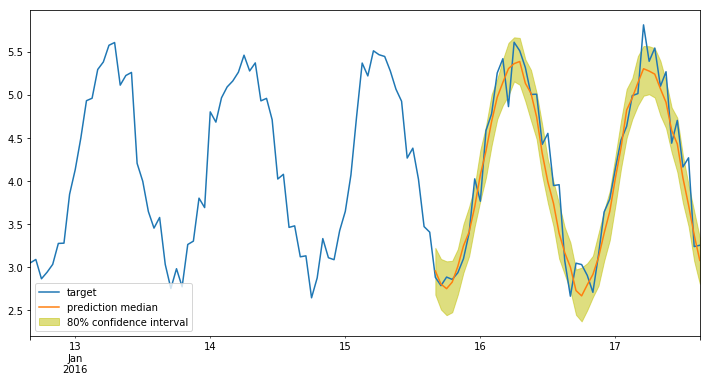

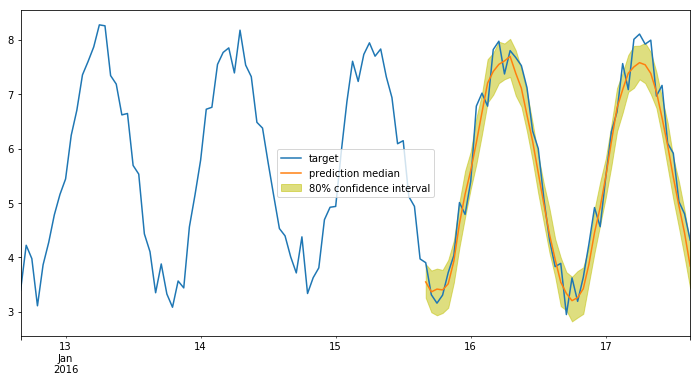

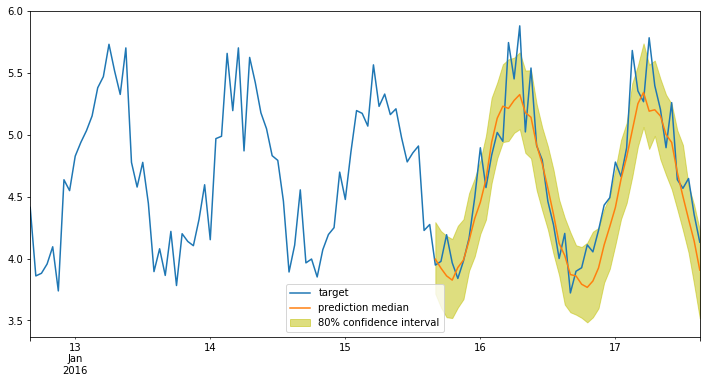

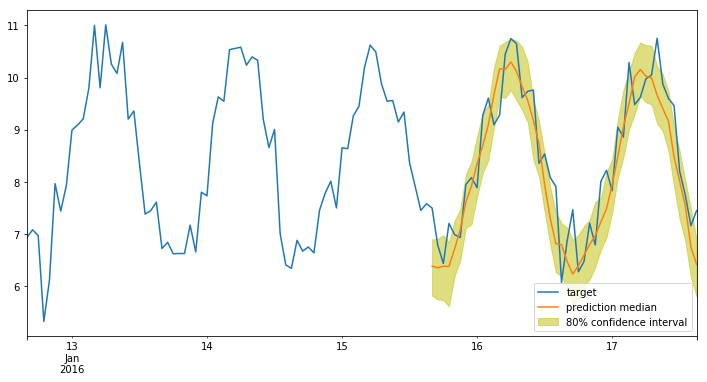

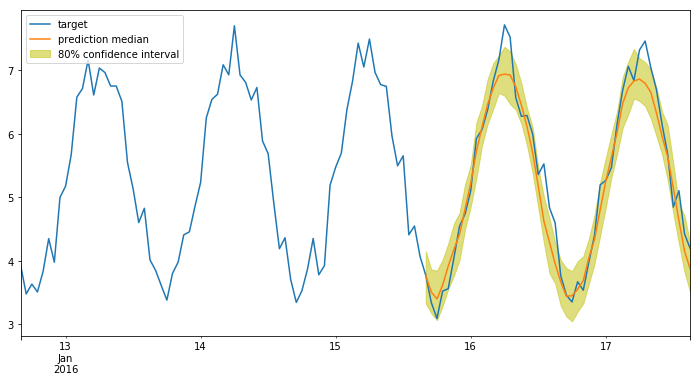

In [30]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

## Delete endpoint

Run this code to automatically delete the endpoint instance and stop getting billed for it...!

In [31]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2018-02-21-18-51-10-073
